In [1]:
#Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

**PSD, FFT**

([], <a list of 0 Text major ticklabel objects>)

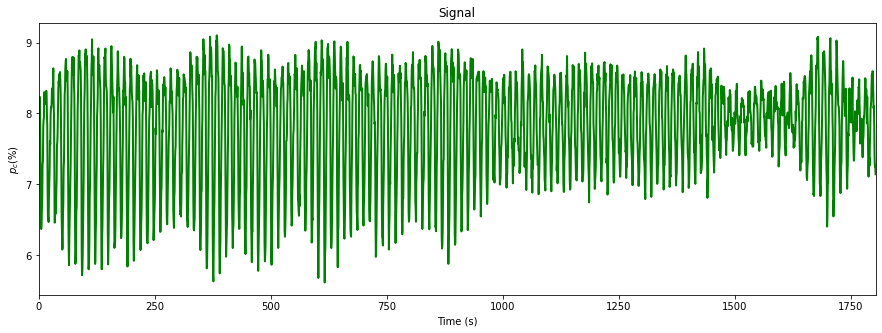

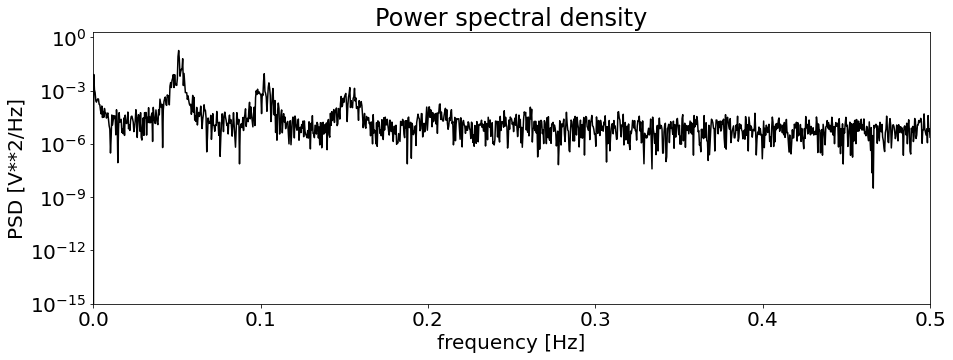

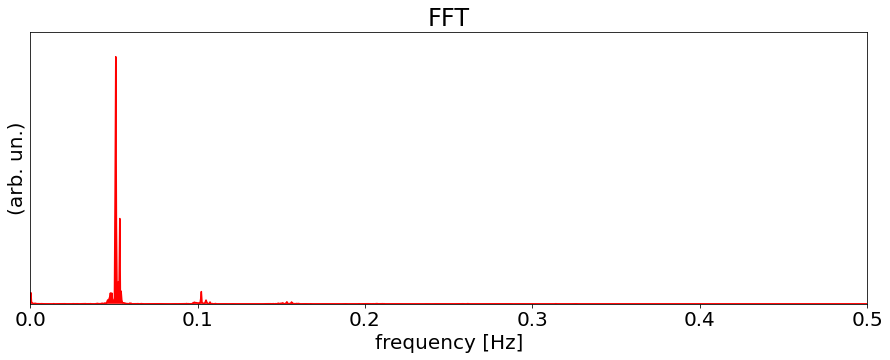

In [2]:
#Name of the file############################################################
name='best_777_T_Bz=5A_Bx=0.08A_exc810_det852.3_5mW_5K_sigma+_PEM_(30min).txt'
#############################################################################

exp_data = np.loadtxt(name, skiprows=1, delimiter='\t')

t=exp_data[:,0]
rho=exp_data[:,3]

#FFT
sp = np.fft.fft(rho)
freq_fft = np.fft.fftfreq(t.shape[-1])
power_fft=(sp.real)**2
power_fft[0]=0

freq, power = signal.periodogram(rho, scaling='spectrum')
#freq, power = signal.welch(rho, scaling='spectrum')

font = {'size': 20}

#Main signal
plt.figure(figsize=(15, 5))
plt.title(r'Signal')
plt.ylabel("$p_c$(%)")
plt.xlabel("Time (s)")
plt.plot(t, rho, 'g', lw=2)
plt.xlim([0,max(t)])
plt.rc('font', **font)

#Power spectrum
plt.figure(figsize=(15, 5))
plt.title(r'Power spectral density')
plt.semilogy(freq, power, 'k')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
axes = plt.gca()
axes.set_xlim([0,0.5])
axes.set_ylim([10**-15,max(power)+max(power)*10])

#FFT
plt.figure(figsize=(15, 5))
plt.title(r'FFT')
plt.plot(freq, power, 'r')
axes = plt.gca()
axes.set_xlim([0,0.5])
axes.set_ylim([0,max(power)+max(power)*0.1])
axes.fill_between(freq, 0, power, facecolor='red')
plt.xlabel(r'frequency [Hz]')
plt.ylabel(r'(arb. un.)')
plt.yticks([])

**Autocorrelation**

The autocorrelation of a signal describes the similarity of a signal against a time-shifted version of itself. For a signal $x$, the autocorrelation $r$ is:
$$r(k)=∑_nx(n)x(n−k)$$
 
In this equation, $k$ is often called the lag parameter.  $r(k)$ is maximized at  $k=0$ and is symmetric about $k$.
The autocorrelation is useful for finding repeated patterns in a signal. For example, at short lags, the autocorrelation can tell us something about the signal's fundamental frequency. For longer lags, the autocorrelation may tell us something about the tempo of a musical signal.

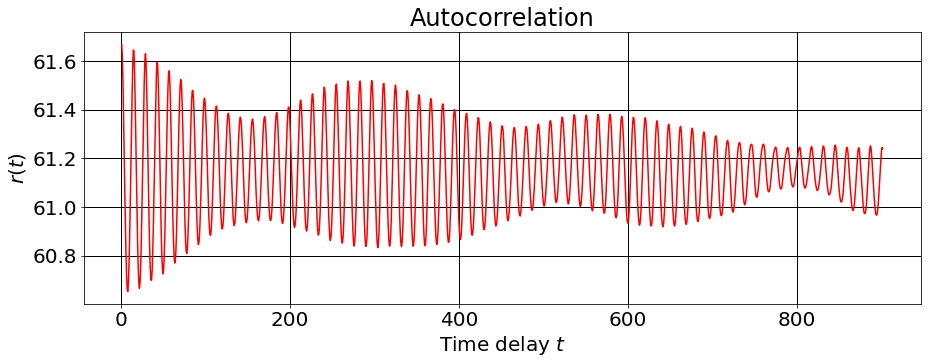

In [3]:
N = len(rho)
fvi = np.fft.fft(rho, n=2*N)
acf = np.real(np.fft.ifft(fvi * np.conjugate(fvi))[:N])
acf = acf/(N - np.arange(N))

plt.figure(figsize=(15, 5))
plt.title(r'Autocorrelation')
plt.xlabel(r'Time delay $t$')
plt.ylabel(r'$r(t)$')
plt.plot(t[0:len(acf)-int(len(acf)/2)], acf[0:len(acf)-int(len(acf)/2)], 'r')
plt.grid(color='black', linewidth=1)
plt.rc('font', **font)


**Embedding time**

The time delayed mutual information was suggested by Fraser and Swinney as a tool to determine a reasonable delay: Unlike the autocorrelation function, the mutual information takes into account also nonlinear correlations. One has to compute
$$
S = - \sum_{ij} p_{ij}(\tau) ln \frac{p_{ij}(\tau)}{p_ip_j}, 
$$
where for some partition on the real numbers $p_{ij}$ is the probability to find a time series value in the $i$-th interval, and $p_{ij}(\tau)$ is the joint probability that an observation falls into the $i$-th interval and the observation time $\tau$ later falls into the $j$-th. In theory this expression has no systematic dependence on the size of the partition elements and can be quite easily computed. There exist good arguments that if the time delayed mutual information exhibits a marked minimum at a certain value of $\tau$, then this is a good candidate for a reasonable time delay. However, these arguments have to be modified when the embedding dimension exceeds two. Moreover, as will become transparent in the following sections, not all applications work optimally with the same delay. Since we are not really interested in absolute values of the mutual information here but rather in the first minimum, the minimal implementation given here seems to be sufficient.

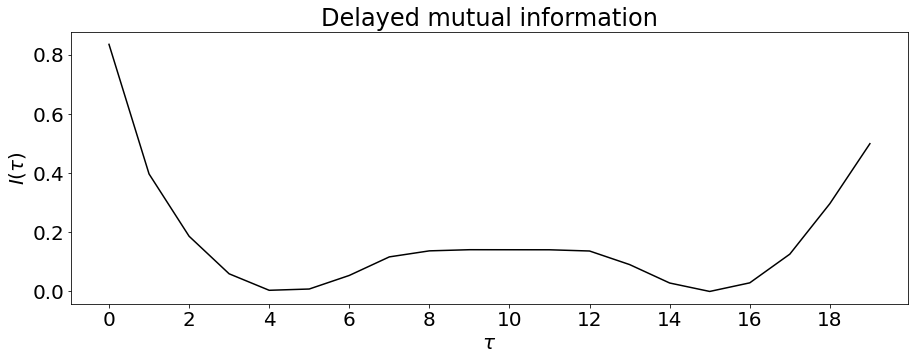

In [4]:
def mut(x, y, bins=32):
    """
    Calculates mutual information, I = S(x) + S(y) - S(x,y), between x and y.
    S(x) is the Shannon entropy.
    _____
    Input (x : array, y : array, bins : int {bins for histogram})
    Output (i : float {mutual information})
    """
    p_x = np.histogram(x, bins)[0]
    p_y = np.histogram(y, bins)[0]
    p_xy = np.histogram2d(x, y, bins)[0].flatten()

    #Recalculate frequencies into  the probabilities
    p_x = p_x[p_x > 0] / np.sum(p_x)
    p_y = p_y[p_y > 0] / np.sum(p_y)
    p_xy = p_xy[p_xy > 0] / np.sum(p_xy)

    #Calculate the Shannon entropies
    Sh_x = np.sum(p_x * np.log2(p_x))
    Sh_y = np.sum(p_y * np.log2(p_y))
    Sh_xy = np.sum(p_xy * np.log2(p_xy))

    return Sh_xy - Sh_x - Sh_y


def tdmut(x, tau, bins=32):
    """
    Calculate the time-delayed mutual information.
    _____
    Input (x : array {1d time series}, tau : int {maximal time delay}, bins : int {bins for histogram})
    Output (arr : float {array with the time-delayed mutual information})
    """
    n = len(x)
    
    tau_max = min(n, tau)

    arr = np.empty(tau_max)
    
    arr[0] = mut(x, x, bins)

    for i in range(1, tau_max):
        arr[i] = mut(x[:-i], x[i:], bins)

    return arr

tau = 20

mutual_inf = tdmut(rho, tau=tau, bins=2)

#Plotting the delayed mutual information
plt.figure(figsize=(15, 5))
plt.plot(mutual_inf, label=(r'Bins = 2'), c='k')
plt.xticks(np.arange(0, tau, 2.0))
plt.title(r'Delayed mutual information')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$I(\tau)$')
plt.show()

**False Nearest Neighbors**

As a test for determinism - method of false nearest neighbors introduced by Kennel et al. (1992). It was originally developed as an alternative to the approach of observing the saturation in invariants to determine the minimum embedding dimension required to reconstruct an attractor. If the attractor has not unfolded properly, it will contain a large number of “false nearest neighbors,” i.e., points that are close together solely due to trajectory crossings caused by the projection of the attractor onto a phase space of smaller dimension. Such neighbors no longer remain close once we increase the embedding dimension, telling us that the attractor cannot be fully unfolded at the chosen embedding dimension. Operationally, we consider a point $y^{(d)}_i$ and its nearest neighbor $y^{(d)}_{n (i,d)}$ in the $d$-dimensional reconstructed phase space as false if
$$
\frac{|x_{i+d\tau} - x_{n(i,d)+d\tau}|} {||y^{(d)}_i - y^{(d)}_{n(i,d)} ||}>A,
$$
where $||\cdot||$ is the Euclidean norm and $A$ is a suitable threshold. We test this condition for all points in the phase space and compute the total fraction of false near neighbors for each $d$. If this fraction becomes zero at a finite, and preferably small, $d$ (the minimum embedding dimension $d_{min}$), then we can conclude that the attractor has properly unfolded and that the time series comes out of a deterministic process. In other words, the system generating the time series is low-dimensional enough to allow its attractor to be embedded in a phase space of $d_{min}$ dimensions.

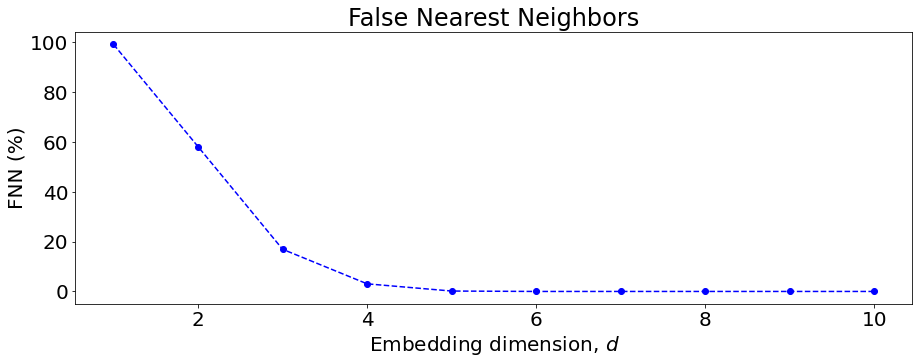

In [34]:
from scipy.spatial import cKDTree as KDTree

#Delay from mutual information
r_delay=4

#Number of calculated embedding dimension:
m0=10
dim = np.arange(1, m0 + 1)


def delayed_vectros(x, dim, tau):
    """
    Calculates the time-delayed vectors from a time series.
    _____
    Input (x : array {time series}, dim : int {embedding dimension}, tau : int {time delay})
    Output (n-dim array {time-delayed array})
    """
    m = len(x) - tau * (dim - 1)
        
    return np.asarray([x[i:i + tau * (dim - 1) + 1:tau] for i in range(m)])


def n_neighbors(x, window=0):
    """
    Finds the nearest neighbors for all points in the array with KDTree search (SciPy).
    _____
    Input (y : n-dim array {time-delayed vectors}, window : int {Theiler window})
    Output (indices : array {indices of near neighbors}, distances : array {neighbor distances})
    """
    n = len(x)
    max_n = 2 * (window + 1) + 1
    indices = np.empty(n, dtype=int)
    distances = np.empty(n)
    
    tree = KDTree(x)
    
    for i, j in enumerate(x):
        
        for k in range(2, max_n + 2):
            dist, index = tree.query(j, k=k, p=np.inf)
            valid = (np.abs(index - i) > window) & (dist > 0)

            if np.count_nonzero(valid):
                distances[i] = dist[valid][0]
                indices[i] = index[valid][0]
                break
                
    return np.squeeze(indices), np.squeeze(distances)


def fnn(d, x, tau, threshold=10):
    y1 = delayed_vectros(x[:-tau], d, tau)
    y2 = delayed_vectros(x, d + 1, tau)

    index, dist = n_neighbors(y1)

    # Kennel's test
    f = np.abs(y2[:, -1] - y2[index, -1]) / dist > threshold

    return np.mean(f)
    

f_nn = [100 * fnn(i, rho, tau=r_delay) for i in dim]

#Plotting the FNN
plt.figure(figsize=(15, 5))
plt.title(r'False Nearest Neighbors')
plt.xlabel(r'Embedding dimension, $d$')
plt.ylabel(r'FNN (%)')
plt.plot(dim, f_nn, 'bo--')
plt.show()